# Рекомендация тарифов

Ряд клиентов компании "N" пользуются архивными тарифами.  Необходимо построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

`Цель:`построить модель для задачи классификации с максимально большим значением *accuracy*, которая выберет подходящий тариф.

`Уточнение:` Предобработка данных не требуется.

`Критерий приема:`доля правильных ответов 0.75

`Входные данные:` данные о поведении клиентов, которые уже перешли на новые тарифы, файл users_behavior.csv

`Описание данных:`

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Изучение файла

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
from joblib import dump
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.dummy import DummyClassifier

from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Из основной статистике данных видно, что среднее и максимальное значение некоторых признаков сильно отличается.

Построим боксплоты, чтобы отследить выбросы

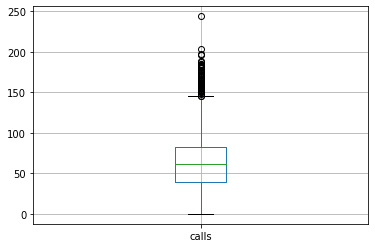

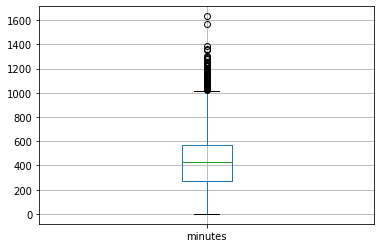

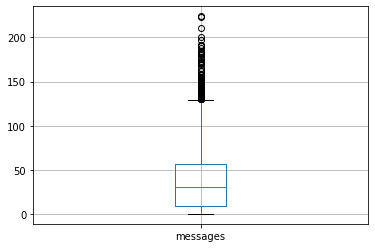

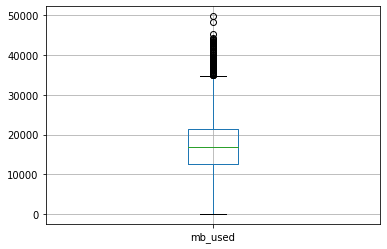

In [5]:
par_list = ['calls','minutes','messages','mb_used']


for par in par_list:
    df.boxplot(column =par)
    plt.show()

Часть выбросов может относится к данным пользователей ультра, посмотрим данные только для этих пользователей

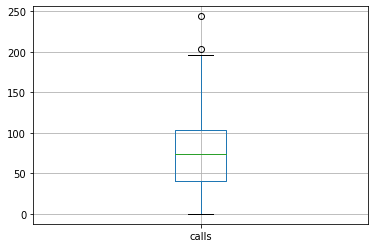

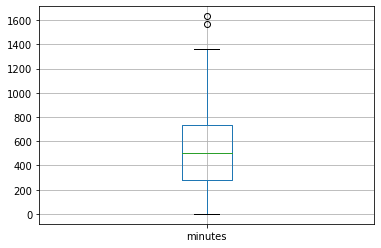

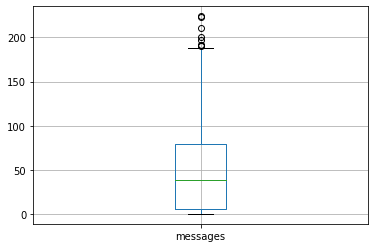

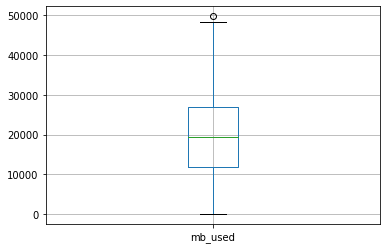

In [6]:
par_list = ['calls','minutes','messages','mb_used']


for par in par_list:
    df.loc[df['is_ultra']==1].boxplot(column =par)
    plt.show()

Проверим данные на дубликаты.

In [7]:
df.duplicated().sum()

0

Возьмем 99% доверительный интервал по каждому признаку, чтобы отсеить максимальные выбросы.

In [9]:
par_list = ['calls','minutes','messages','mb_used']


for par in par_list:
    mean, sigma = np.mean(df[par]), np.std(df[par])

    conf_int = stats.norm.interval(0.99, loc=mean, scale=sigma) 
    print(conf_int)
    
    df = df.loc[df[par] >= 0 ] # в наших данных не должно быть отрицательных значений, поэтому поставила >= 0
    df = df.loc[df[par] < conf_int[1]]
    
df.describe()

(-22.55899760698864, 148.63678229896126)
(-125.67655761416404, 974.8969696585382)
(-53.361848467704995, 128.1212613585793)
(-1952.9776180339904, 35705.61104744768)


,calls,minutes,messages,mb_used,is_ultra
count,3005.000000,3005.000000,3005.000000,3005.000000,3005.000000
mean,60.162729,418.108582,34.415973,16514.509677,0.263228
std,28.818821,203.727250,29.893464,6771.678285,0.440458
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,271.430000,9.000000,12272.830000,0.000000
50%,61.000000,421.270000,28.000000,16617.340000,0.000000
75%,80.000000,550.750000,53.000000,20811.880000,1.000000
max,146.000000,974.190000,128.000000,35689.600000,1.000000


Проверим корреляцию данных.

In [10]:
par = ['calls','minutes','messages','mb_used']


corr_df=df[par]  
cor= corr_df.corr(method='pearson')
print(cor)

             calls   minutes  messages   mb_used
calls     1.000000  0.977310  0.142754  0.282173
minutes   0.977310  1.000000  0.141480  0.274934
messages  0.142754  0.141480  1.000000  0.129132
mb_used   0.282173  0.274934  0.129132  1.000000


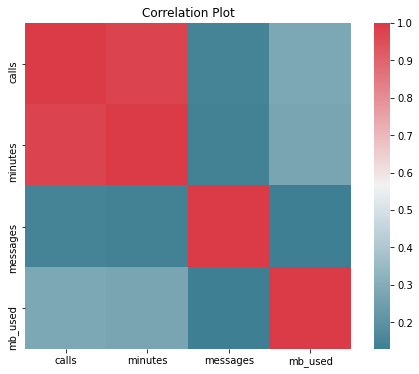

In [11]:
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

## Разбиение данных на выборки

Нам необходимо три набора данных в соотношении 3:1:1

In [12]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

print(df.loc[df['is_ultra'] == 0].shape, df.loc[df['is_ultra'] == 1].shape) # изначальное распределение меток ~ 3:1

features_train, features_test, target_train, target_test = train_test_split(
   features, target, test_size=0.4, random_state=12345,stratify=target)

print(f"Количество строк в target_train по классам: {np.bincount(target_train)}")
print(f"Количество строк в target_test по классам: {np.bincount(target_test)}")
print()


features_test, features_valid, target_test, target_valid = train_test_split(
   features_test, target_test, test_size=0.5, random_state=12345, stratify= target_test)


print(f"Количество строк в target_train по классам: {np.bincount(target_train)}")
print(f"Количество строк в target_valid по классам: {np.bincount(target_valid)}")

(2214, 5) (791, 5)
Количество строк в target_train по классам: [1328  475]
Количество строк в target_test по классам: [886 316]

Количество строк в target_train по классам: [1328  475]
Количество строк в target_valid по классам: [443 158]


    features_train - обучающие признаки
    target_train - обучающий целевой признак

    features_valid - валидационные признаки
    target_valid - валидационный целевой признак

    features_test -  тестовые признаки
    target_test - тестовый целевой признак

## Исследование моделей

Рассмотрим три модели: Дерево классификации, случайный лес и логистическую регрессию.

### Дерево классификации

В цикле подберем наиболее подходящую глубину дерева, максимальное значение выбрано по кол-ву признаков.

In [13]:
best_model_tree_classifier = None
best_result = 0
for depth in range(1, 4):
    model = DecisionTreeClassifier(random_state=12345, max_depth= depth) 
    model.fit(features_train,target_train) 
    predictions = model.predict(features_valid) 
    result = accuracy_score(target_valid, predictions)
    if result > best_result:
        best_model_tree_classifier = model
        best_result = result
print("Accuracy лучшей модели на обучающей выборке:", accuracy_score(target_train, best_model_tree_classifier.predict(features_train)))
print("Accuracy лучшей модели на валидационной выборке:", best_result, best_model_tree_classifier)

Accuracy лучшей модели на обучающей выборке: 0.7848031059345535
Accuracy лучшей модели на валидационной выборке: 0.7920133111480865 DecisionTreeClassifier(max_depth=2, random_state=12345)


### Случайный лес

Для подбора параметров случайного леса воспользуемся GridSearchCV,  с параметром кросс-валидации равном 5.

In [15]:
rfc=RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_depth' : [4,5,6,7,8],
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(features_train, target_train)


print(CV_rfc.best_params_)

{'max_depth': 8, 'n_estimators': 200}


In [16]:
best_model_forest_classifier = RandomForestClassifier(random_state=42,  n_estimators= 200, max_depth=6)

In [17]:
best_model_forest_classifier.fit(features_train, target_train)

RandomForestClassifier(max_depth=6, n_estimators=200, random_state=42)

In [18]:
print("Accuracy лучшей модели на обучающей выборке:",accuracy_score(target_train, best_model_forest_classifier.predict(features_train)))
print("Accuracy лучшей модели на валидационной выборке:", best_result, best_model_forest_classifier)

Accuracy лучшей модели на обучающей выборке: 0.841375485302274
Accuracy лучшей модели на валидационной выборке: 0.7920133111480865 RandomForestClassifier(max_depth=6, n_estimators=200, random_state=42)


### Логистическая регрессия 

Реализуем модель логистической регрессии.

In [19]:
logistic_regression_model = LogisticRegression(random_state = 12345,solver='lbfgs', max_iter=1000, C = 10000)
logistic_regression_model.fit(features_train,target_train)
logistic_regression_model.predict(features_valid)

#dump(logistic_regression_model, 'model_9_1.joblib')

print("Accuracy модели на обучающей выборке:",logistic_regression_model.score(features_train,target_train))
print("Accuracy модели на валидационной выборке:",logistic_regression_model.score(features_valid,target_valid))

Accuracy модели на обучающей выборке: 0.7365501941209096
Accuracy модели на валидационной выборке: 0.7371048252911814


In [20]:
best_model_logistic_reg = None
best_result = 0

for regularization_s in [1,10,100,1000]:
    for solver in ['lbfgs', 'liblinear','sag', 'saga']:
        model = LogisticRegression(random_state = 12345,solver=solver, max_iter=100000, C = regularization_s)
        model.fit(features_train,target_train)
        model.predict(features_valid)
        result = model.score(features_valid,target_valid)
        #print(model,result)
            
        if result > best_result:
            best_model_logistic_reg =  model 
            best_result = result 
            
            
print('Лучшая конфигурация',best_model_logistic_reg,best_result)       

Лучшая конфигурация LogisticRegression(C=1, max_iter=100000, random_state=12345) 0.7371048252911814


In [21]:
poly = PolynomialFeatures(degree=3)
feature_poly = poly.fit_transform(features_train)

In [22]:
logit = LogisticRegression(C=1, max_iter=1e20, random_state=12345)
logit.fit(feature_poly, target_train)

logit.score(feature_poly, target_train)

0.7359955629506378

## Проверка модель на тестовой выборке

### Проверка модели дерева классификации

In [24]:
predictions_tree = best_model_tree_classifier.predict(features_test)
print("Accuracy модели на тестовой выборке:",accuracy_score(target_test, predictions_tree))

Accuracy модели на тестовой выборке: 0.778702163061564


### Проверка модели случайный лес

In [25]:
predictions_forest = best_model_forest_classifier.predict(features_test)
print("Accuracy модели на тестовой выборке:",accuracy_score(target_test,predictions_forest))

Accuracy модели на тестовой выборке: 0.8036605657237936


### Проверка модели логистической регрессии

In [26]:
predictions_logistic = logistic_regression_model.predict(features_test)
print("Accuracy модели на тестовой выборке:",accuracy_score(target_test,predictions_logistic))

Accuracy модели на тестовой выборке: 0.7371048252911814


Наилучший результат показывает модель случайного леса.

## (бонус) Проверка моделей на адекватность

In [27]:
mean_squared_error(target_test,predictions_tree)

0.22129783693843594

In [28]:
mean_squared_error(target_test,predictions_forest)

0.19633943427620631

In [29]:
mean_squared_error(target_test,predictions_logistic)

0.2628951747088186

In [30]:
predictions_mean = pd.Series(target.mean(), index=target.index) 
mse = mean_squared_error(target, predictions_mean)
mse

0.19393899795404776

Создадим константную модель, чтобы сравнить результат ее работы с результатами наших моделей.

In [31]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, target_train)

dummy_clf.predict(features_valid)

dummy_clf.score(features_train, target_train)

0.7365501941209096

### Вывод:

В результате работы были опробоованы три модели классификации: дерево классификации, случайный лес и логистическая регрессия.

Был осуществлен подбор гиперпараметров, а также кросс-валидация (для модели случайного леса).

Модель случайного леса с параметрами n_estimators= 200, max_depth=6, дает наилучший результат 0.8036, что отвечает запросу заказчика.